In [32]:
from dataclasses import dataclass
from datasets import load_dataset
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch 
from torch.utils.data import TensorDataset
from diffusers import UNet2DModel
from PIL import Image
from diffusers import DDPMScheduler
import torch.nn.functional as F
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
import math
import os

torch.manual_seed(0)

In [2]:
@dataclass
class TrainingConfig:
    '''
    Class for training parameters
    '''
    
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [3]:
# Load the pickle files using the exact file paths
x_data_path = "/home/maddie/Documents/underwater/DeepCFD/dataX.pkl"
y_data_path = "/home/maddie/Documents/underwater/DeepCFD/dataY.pkl"

with open(x_data_path, "rb") as f:
    x = pickle.load(f)

with open(y_data_path, "rb") as f:
    y = pickle.load(f)

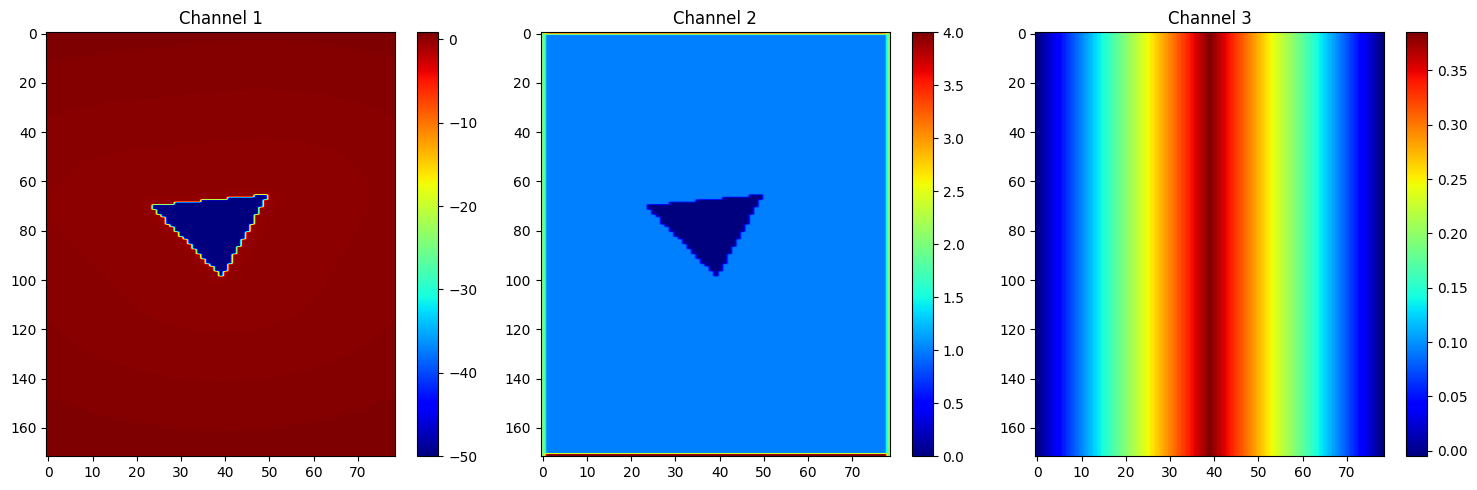

In [4]:
# Set up the matplotlib figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns for the 3 channels

# Plot each channel
for i in range(3):  # Loop over the channels
    ax = axs[i]  # Get the current axis
    channel_data = x[12, i, :, :] # Get the data for the first sample, channel i
    im = ax.imshow(channel_data, cmap='jet', aspect='auto')  # Plot the data
    ax.set_title(f'Channel {i+1}')  # Set the title for the channel
    fig.colorbar(im, ax=ax)  # Add a colorbar for each plot

# Display the plot
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


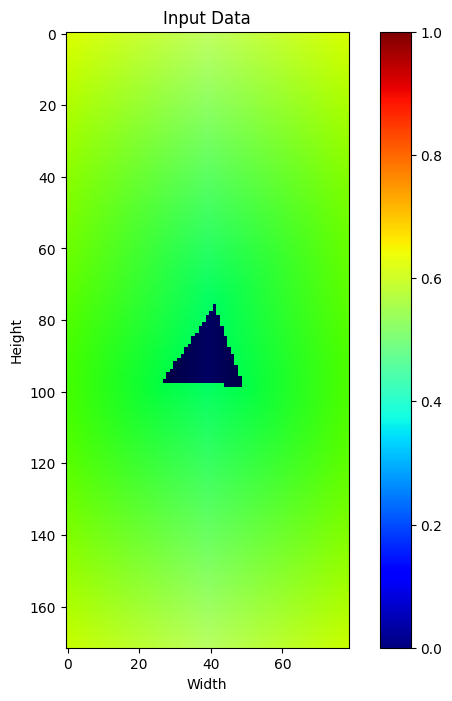

In [5]:
# Visualize input data
# Assuming you want to randomly sample an input data point
index = 301

# Plotting only the input data (input features)
input_data = x[index]

plt.figure(figsize=(8, 8))
plt.imshow(input_data.transpose(1, 2, 0), cmap = "jet")  # Transpose dimensions for correct display
plt.title('Input Data')
plt.xlabel('Width')
plt.ylabel('Height')
plt.colorbar()
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

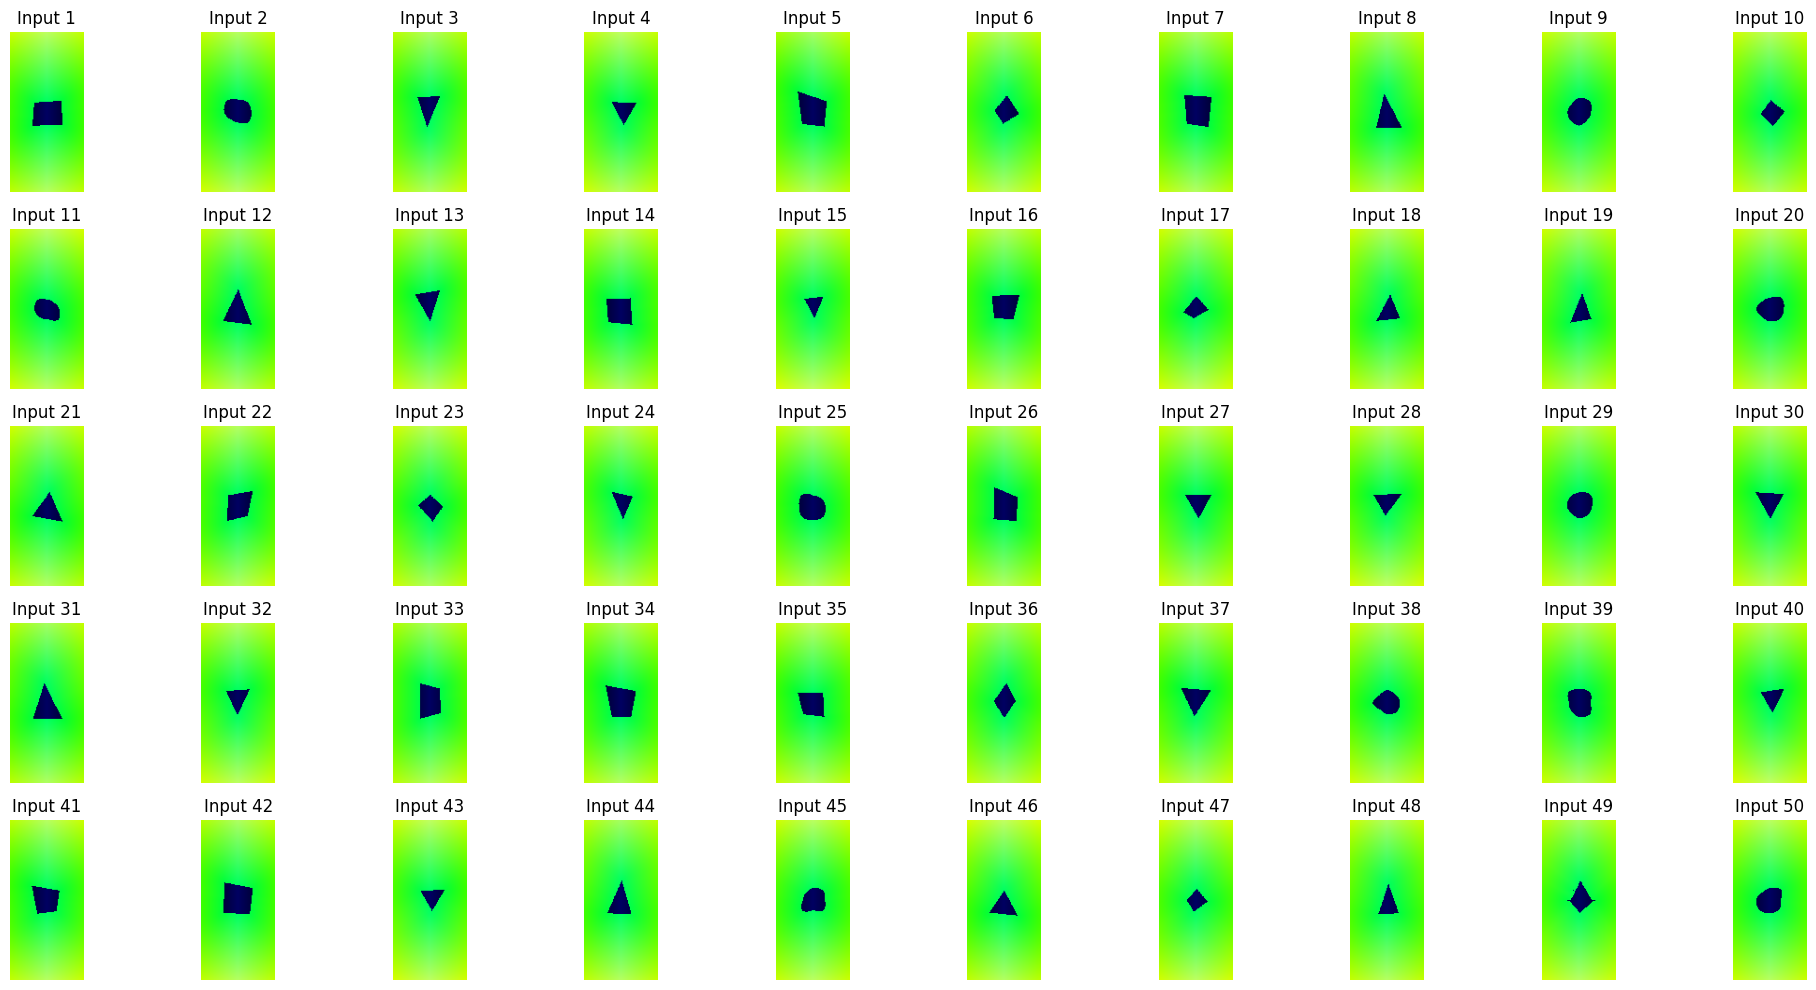

In [6]:
# Plotting the first 50 inputs in a 5x10 grid subplot
plt.figure(figsize=(20, 10))

for i in range(50):
    plt.subplot(5, 10, i + 1)
    input_data = x[i]
    plt.imshow(input_data.transpose(1, 2, 0))  # Transpose dimensions for correct display
    plt.title('Input {}'.format(i+1))
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
x.shape
x[:,2].min()




-0.005

In [8]:
# Preprocess the data

# turn the input in a pytorch tensor
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

# Shuffle data 
indices = list(range(len(x)))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Normalize the data [-1,1] for each channel 
def normalize_tensor(tensor):
    min_val = torch.amin(tensor, dim=(0, 2, 3), keepdim=True)  # min over all axes except channels
    max_val = torch.amax(tensor, dim=(0, 2, 3), keepdim=True)  # max over all axes except channels
    # Normalize to [-1, 1]
    tensor_normalized = 2 * ((tensor - min_val) / (max_val - min_val)) - 1
    return tensor_normalized

# normalize the input and output data
x = normalize_tensor(x)
y = normalize_tensor(y)

def test_normalization(normalize_tensor):

    # Iterate over each channel to check and print min/max values
    for c in range(normalize_tensor.size(1)):  # tensor.size(1) gives the number of channels
        channel_normalized = normalize_tensor[:, c, :, :]
        
        # Calculate min and max values for the normalized channel
        min_val = torch.amin(channel_normalized).item()
        max_val = torch.amax(channel_normalized).item()
        
        # Print the min and max values
        print(f'Channel {c+1}: Min = {min_val}, Max = {max_val}')
        
        # Check that min and max values are -1 and 1, respectively
        assert min_val >= -1 and max_val <= 1, f"Channel {c+1} is not properly normalized."
    
    print("All checks passed. The tensor is normalized correctly.")

# Assuming normalize_tensor is defined as before, you can now test this function:
print("Check if input is normalized: ")
test_normalization(x)
print("\nCheck if output is normalized: ")
test_normalization(y) 

Check if input is normalized: 
Channel 1: Min = -1.0, Max = 1.0
Channel 2: Min = -1.0, Max = 1.0
Channel 3: Min = -1.0, Max = 1.0
All checks passed. The tensor is normalized correctly.

Check if output is normalized: 
Channel 1: Min = -1.0, Max = 1.0
Channel 2: Min = -1.0, Max = 1.0
Channel 3: Min = -1.0, Max = 1.0
All checks passed. The tensor is normalized correctly.


In [9]:
# Function for dividing the dataset 
def split_tensors(*tensors, ratio):
    assert len(tensors) > 0
    split1, split2 = [], []
    count = len(tensors[0])
    for tensor in tensors:
        assert len(tensor) == count
        split1.append(tensor[:int(len(tensor) * ratio)])
        split2.append(tensor[int(len(tensor) * ratio):])
    if len(tensors) == 1:
        split1, split2 = split1[0], split2[0]
    return split1, split2

# Split the data into training and testing sets (70/30)
train_data, test_data = split_tensors(x,y, ratio=0.7)

# Create PyTorch datasets 
train_dataset = TensorDataset(*train_data)

test_dataset = TensorDataset(*test_data)
test_x, test_y = test_data[:] # split test data into x and y

# Load data into PyTorch DataLoader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)


In [23]:
# Create Scheduler 
noise_scheduler = DDPMScheduler(num_train_timesteps=1000) # DDPM scheduler with 1000 timesteps

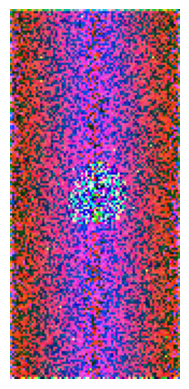

In [24]:
# Visualize the effect of noise on an image
def visualize_noisy_image(image_tensor, noise_scheduler, timesteps):
    # Generate random noise
    noise = torch.randn(image_tensor.shape)

    # Add noise using the scheduler
    noisy_image = noise_scheduler.add_noise(image_tensor, noise, timesteps)

    # Convert the noisy image for visualization
    noisy_image_to_display = Image.fromarray(((noisy_image.permute(0, 2, 3, 1).detach() + 1) * 127.5).type(torch.uint8).numpy()[0])

    # Display the image
    plt.imshow(noisy_image_to_display)
    plt.axis('off')
    plt.show()

# Visualize a noisy version of the first sample in the training data
# You can change the timestep to see the effect of different noise levels
visualize_noisy_image(x[0:1], noise_scheduler, timesteps=torch.LongTensor([50]))

In [31]:
# Optimizer:  update the model's parameters based on the computed gradients during the training process
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

# Learning rate scheduler: adjust the learning rate of the optimizer during the training process
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [33]:
# Setup NN model
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)


In [ ]:
model = UNet2DConditionalModel( 
    sample_size: Optional = None
    in_channels: int = 4
    out_channels: int = 4
    center_input_sample:  bool = False
    flip_sin_to_cos: bool = Tru
    freq_shift: int = 0
    down_block_types: Tuple = ('CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'DownBlock2D'
    mid_block_type: Optional = 'UNetMidBlock2DCrossAttn'
    up_block_types:  Tuple = ('UpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D')
    only_cross_attention:  Union = False
    block_out_channels: Tuple = (320, 640, 1280, 1280)
    layers_per_block:  Union = 2
    downsample_padding: int = 1
    mid_block_scale_factor: float = 1
    dropout: float = 0.0
    act_fn: str = 'silu'
    norm_num_groups: Optional = 32
    norm_eps: float = 1e-05
    cross_attention_dim: Union = 1280
    transformer_layers_per_block: Union = 1
    reverse_transformer_layers_per_block: Optional = None
    econder_hid_dim: Optional = None
    encoder_hid_dim_type: Optional = None
    attention_head_dim: Union = 8
    num_attention_heads: Union = None
    dual_cross_attention: bool = False
    use_linear_projection: bool = False
    class_embed_type: Optional = None
    addition_embed_type: Optional = None
    addition_time_embed_dim: Optional = None
    num_class_embeds:  Optional = None
    upcast_attention: bool = False
    resnet_time_scale_shift: str = 'default'
    resnet_skip_time_act: bool = False
    resent_out_scale_factor: float = 1.0
    time_embedding_type: str = 'positional'
    time_embedding_dim: Optional = None
    time_embedding_act_fn: Optional = None
    timestep_post_act: Optional = None
    time_cond_proj_dim: Optional = None
    conv_in_kernel: int = 3
    conv_out_kernel: int = 3
    projection_class_embddings_input_dim: Optional = None
    attention_type: str = 'default'
    class_embeddings_concat:  bool = False
    mid_block_only_cross_attention: Optional = None
    cross_attention_norm: Optional = None
    addition_embed_type_num_heads: int = 64

)